# Xarray Fundamentals

*This material is adapted from the [Earth and Environmental Data Science](https://earth-env-data-science.github.io/intro.html), from Ryan Abernathey (Columbia University)*.

## Xarray data structures


:::{important}
Like Pandas, xarray has two fundamental data structures:
* a `DataArray`, which holds a single multi-dimensional variable and its coordinates
* a `Dataset`, which holds multiple variables that potentially share the same coordinates
:::

### DataArray

A `DataArray` has four essential attributes:
* `values`: a `numpy.ndarray` holding the array’s values
* `dims`: dimension names for each axis (*e.g.*, `('x', 'y', 'z')`)
* `coords`: a dict-like container of arrays (coordinates) that label each point (e.g., 1-dimensional arrays of numbers, datetime objects or strings)
* `attrs`: an `OrderedDict` to hold arbitrary metadata (attributes)

Let's start by constructing some DataArrays manually 

In [107]:
import numpy as np
import xarray as xr

from matplotlib import pyplot as plt
# %config InlineBackend.figure_format = 'retina'
plt.ion()  # To trigger the interactive inline mode

plt.rcParams['figure.figsize'] = (6,5)

A simple DataArray without dimensions or coordinates isn't much use.

In [108]:
da = xr.DataArray([9, 0, 2, 1, 0])
da

<xarray.DataArray (dim_0: 5)>
array([9, 0, 2, 1, 0])
Dimensions without coordinates: dim_0

We can add a dimension name...

In [109]:
da = xr.DataArray([9, 0, 2, 1, 0], dims=['x'])
da

<xarray.DataArray (x: 5)>
array([9, 0, 2, 1, 0])
Dimensions without coordinates: x

But things get most interesting when we add a coordinate:

In [110]:
da = xr.DataArray([9, 0, 2, 1, 0],
                  dims=['x'],
                  coords={'x': [10, 20, 30, 40, 50]})
da

<xarray.DataArray (x: 5)>
array([9, 0, 2, 1, 0])
Coordinates:
  * x        (x) int64 10 20 30 40 50

`Xarray` has built-in plotting, like `Pandas`.

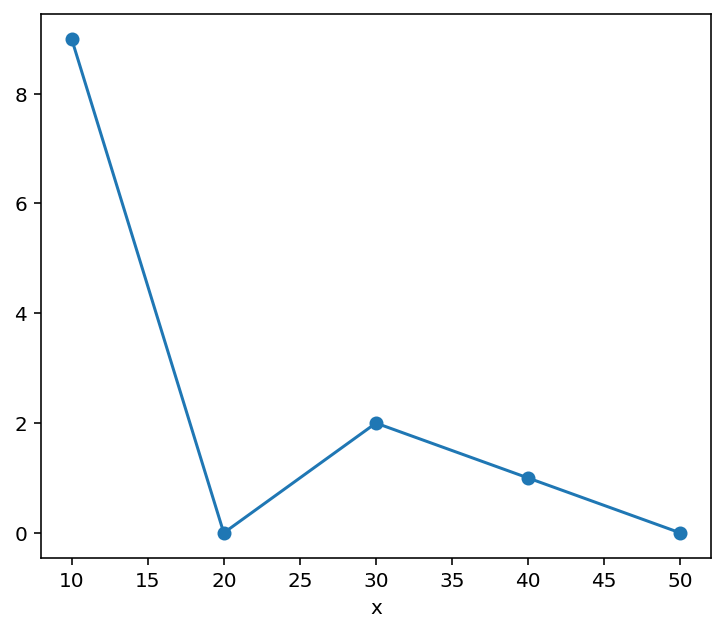

In [111]:
da.plot(marker='o')

### Multidimensional DataArray

If we are just dealing with 1D data, Pandas and Xarray have very similar capabilities. Xarray's real potential comes with multidimensional data.

Let's analyse a multidimensional [ARGO data](https://argo.ucsd.edu/data/) (argo_float_4901412.npz) from ocean profiling floats.

We reload this data and examine its keys.

In [112]:
argo_data = np.load('argo_float_4901412.npz')

In [113]:
list(argo_data.keys())

['S', 'T', 'levels', 'lon', 'date', 'P', 'lat']

The values of the `argo_data` object are numpy arrays.

In [114]:
S = argo_data.f.S
T = argo_data.f.T
P = argo_data.f.P
levels = argo_data.f.levels
lon = argo_data.f.lon
lat = argo_data.f.lat
date = argo_data.f.date
print(S.shape, lon.shape, date.shape, levels.shape)

(78, 75) (75,) (75,) (78,)


Let's organize the data and coordinates of the salinity variable into a DataArray.

In [115]:
da_salinity = xr.DataArray(S, dims=['level', 'date'],
                           coords={'level': levels,
                                   'date': date},)
da_salinity

<xarray.DataArray (level: 78, date: 75)>
array([[35.6389389 , 35.51495743, 35.57297134, ..., 35.82093811,
        35.77793884, 35.66891098],
       [35.63393784, 35.5219574 , 35.57397079, ..., 35.81093216,
        35.58389664, 35.66791153],
       [35.6819458 , 35.52595901, 35.57297134, ..., 35.79592896,
        35.66290665, 35.66591263],
       ...,
       [34.91585922, 34.92390442, 34.92390442, ..., 34.93481064,
        34.94081116, 34.94680786],
       [34.91585922, 34.92390442, 34.92190552, ..., 34.93280792,
        34.93680954, 34.94380951],
       [34.91785812, 34.92390442, 34.92390442, ...,         nan,
        34.93680954,         nan]])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75 76 77
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...

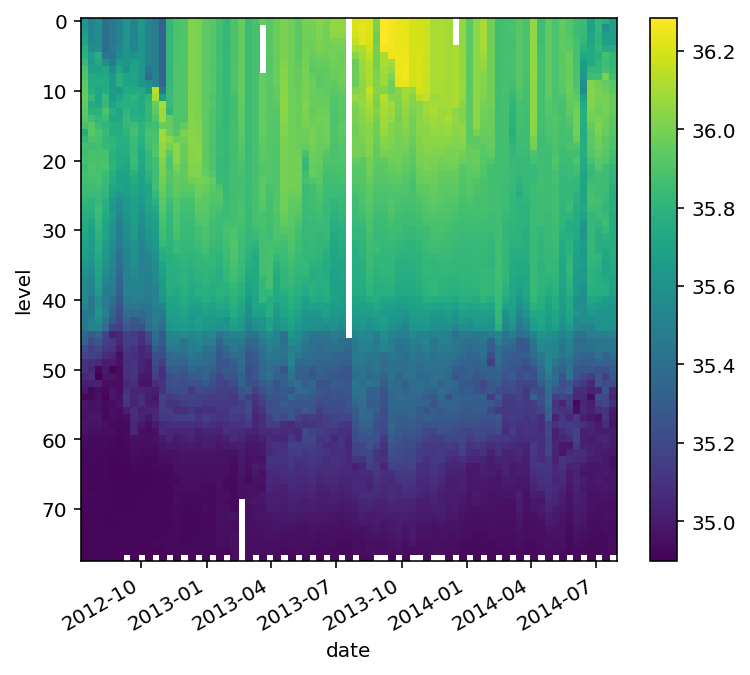

In [116]:
da_salinity.plot(yincrease=False)

Attributes can be used to store metadata. What metadata should you store? The [CF Conventions](http://cfconventions.org/Data/cf-conventions/cf-conventions-1.7/cf-conventions.html#_description_of_the_data) are a great resource for thinking about climate metadata. Below we define two of the required CF-conventions attributes.

In [117]:
da_salinity.attrs['units'] = 'PSU'
da_salinity.attrs['standard_name'] = 'sea_water_salinity'
da_salinity

<xarray.DataArray (level: 78, date: 75)>
array([[35.6389389 , 35.51495743, 35.57297134, ..., 35.82093811,
        35.77793884, 35.66891098],
       [35.63393784, 35.5219574 , 35.57397079, ..., 35.81093216,
        35.58389664, 35.66791153],
       [35.6819458 , 35.52595901, 35.57297134, ..., 35.79592896,
        35.66290665, 35.66591263],
       ...,
       [34.91585922, 34.92390442, 34.92390442, ..., 34.93481064,
        34.94081116, 34.94680786],
       [34.91585922, 34.92390442, 34.92190552, ..., 34.93280792,
        34.93680954, 34.94380951],
       [34.91785812, 34.92390442, 34.92390442, ...,         nan,
        34.93680954,         nan]])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75 76 77
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...
Attributes:
    units:          PSU
    standard_name:  sea_water_salinity

### Datasets

A Dataset holds many DataArrays which potentially can share coordinates. In analogy to pandas:

    pandas.Series : pandas.Dataframe :: xarray.DataArray : xarray.Dataset
    
Constructing Datasets manually is a bit more involved in terms of syntax. The Dataset constructor takes three arguments:

* `data_vars` should be a dictionary with each key as the name of the variable and each value as one of:
  * A `DataArray` or Variable
  * A tuple of the form `(dims, data[, attrs])`, which is converted into arguments for Variable
  * A pandas object, which is converted into a `DataArray`
  * A 1D array or list, which is interpreted as values for a one dimensional coordinate variable along the same dimension as it’s name
* `coords` should be a dictionary of the same form as data_vars.
* `attrs` should be a dictionary.

Let's put together a Dataset with temperature, salinity and pressure all together

In [118]:
argo = xr.Dataset(
        data_vars={'salinity':    (('level', 'date'), S),
                   'temperature': (('level', 'date'), T),
                   'pressure':    (('level', 'date'), P)},
        coords={'level': levels,
                'date': date})
argo

<xarray.Dataset>
Dimensions:      (date: 75, level: 78)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 35.4 ... nan 34.94 nan
    temperature  (level, date) float64 18.97 18.44 19.1 19.79 ... nan 3.714 nan
    pressure     (level, date) float64 6.8 6.1 6.5 5.0 ... 2e+03 nan 2e+03 nan

What about lon and lat? We forgot them in the creation process, but we can add them after

In [119]:
argo.coords['lon'] = lon
argo

<xarray.Dataset>
Dimensions:      (date: 75, level: 78, lon: 75)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
  * lon          (lon) float64 -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 35.4 ... nan 34.94 nan
    temperature  (level, date) float64 18.97 18.44 19.1 19.79 ... nan 3.714 nan
    pressure     (level, date) float64 6.8 6.1 6.5 5.0 ... 2e+03 nan 2e+03 nan

That was not quite right...we want lon to have dimension `date`:

In [120]:
del argo['lon']
argo.coords['lon'] = ('date', lon)
argo.coords['lat'] = ('date', lat)
argo

<xarray.Dataset>
Dimensions:      (date: 75, level: 78)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
    lon          (date) float64 -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
    lat          (date) float64 47.19 46.72 46.45 46.23 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 35.4 ... nan 34.94 nan
    temperature  (level, date) float64 18.97 18.44 19.1 19.79 ... nan 3.714 nan
    pressure     (level, date) float64 6.8 6.1 6.5 5.0 ... 2e+03 nan 2e+03 nan

### Coordinates vs. Data Variables

Data variables can be modified through arithmentic operations or other functions. Coordinates are always keept the same.

In [121]:
argo * 10000

<xarray.Dataset>
Dimensions:      (date: 75, level: 78)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
    lon          (date) float64 -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
    lat          (date) float64 47.19 46.72 46.45 46.23 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 3.564e+05 3.551e+05 ... 3.494e+05 nan
    temperature  (level, date) float64 1.897e+05 1.844e+05 ... 3.714e+04 nan
    pressure     (level, date) float64 6.8e+04 6.1e+04 6.5e+04 ... nan 2e+07 nan

Clearly lon and lat are coordinates rather than data variables. We can change their status as follows:

In [122]:
argo = argo.set_coords(['lon', 'lat'])
argo

<xarray.Dataset>
Dimensions:      (date: 75, level: 78)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
    lon          (date) float64 -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
    lat          (date) float64 47.19 46.72 46.45 46.23 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 35.4 ... nan 34.94 nan
    temperature  (level, date) float64 18.97 18.44 19.1 19.79 ... nan 3.714 nan
    pressure     (level, date) float64 6.8 6.1 6.5 5.0 ... 2e+03 nan 2e+03 nan

The bold format in the representation above indicates that `level` and `date` are "dimension coordinates" (they describe the coordinates associated with data variable axes) while `lon` and `lat` are "non-dimension coordinates". We can make any variable a non-dimension coordiante.

## Working with Labeled Data

Xarray's labels make working with multidimensional data much easier.

### Selecting Data (Indexing)

We can always use regular numpy indexing and slicing on DataArrays

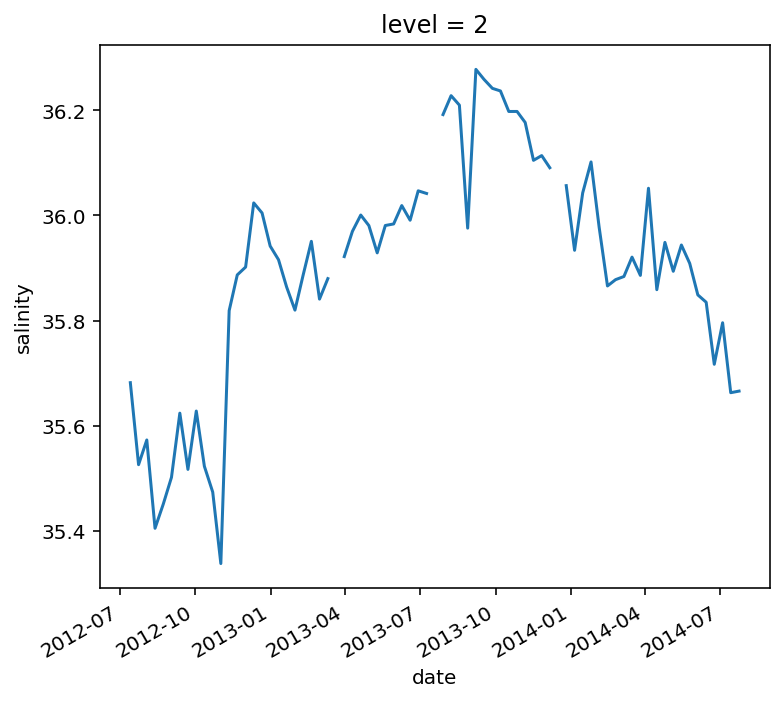

In [123]:
argo.salinity[2].plot()

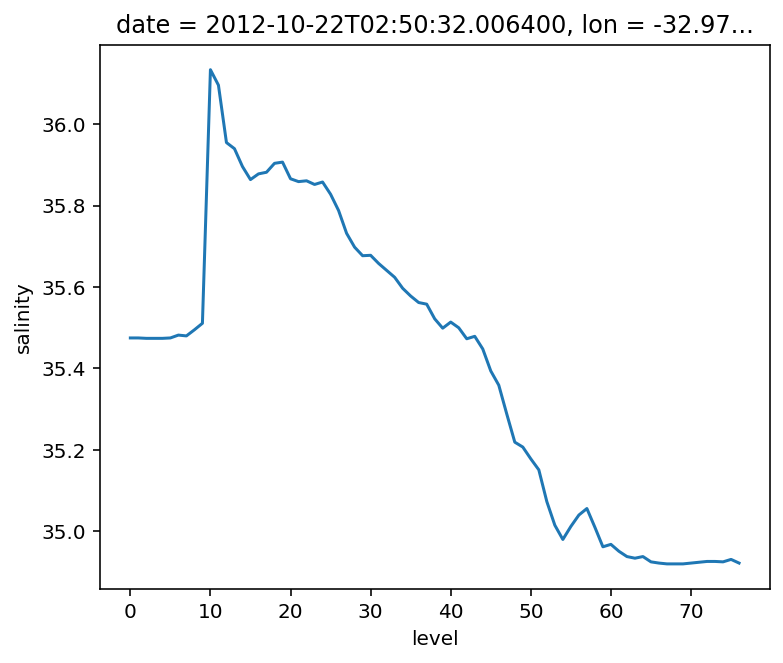

In [124]:
argo.salinity[:, 10].plot()

However, it is often much more powerful to use xarray's `.sel()` method to use label-based indexing.

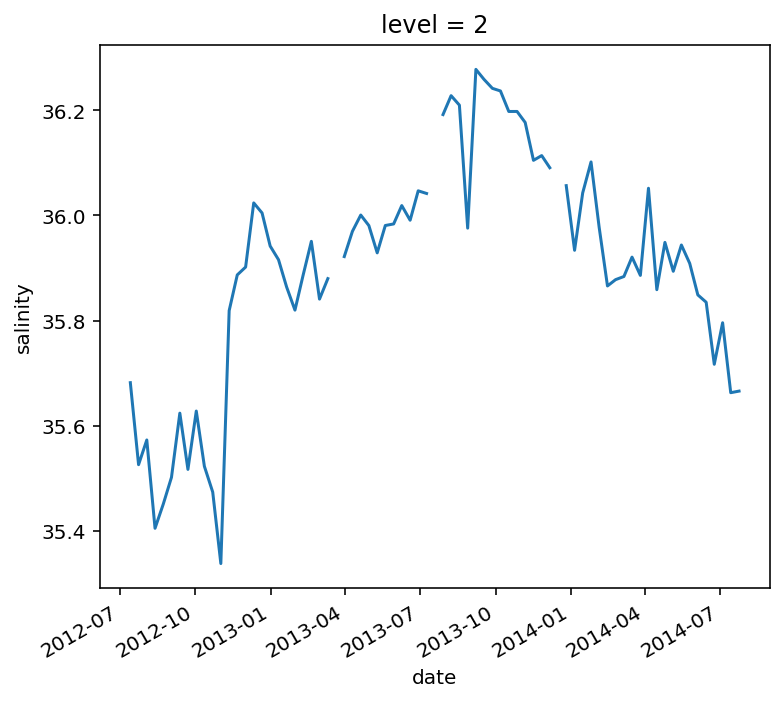

In [125]:
argo.salinity.sel(level=2).plot()

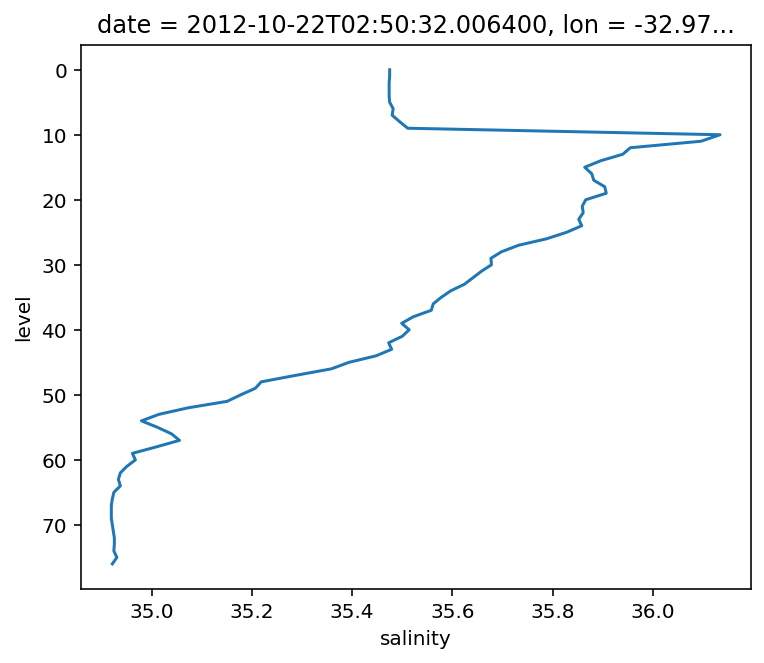

In [126]:
argo.salinity.sel(date='2012-10-22').plot(y='level', yincrease=False)

`.sel()` also supports slicing. Unfortunately we have to use a somewhat awkward syntax, but it still works.

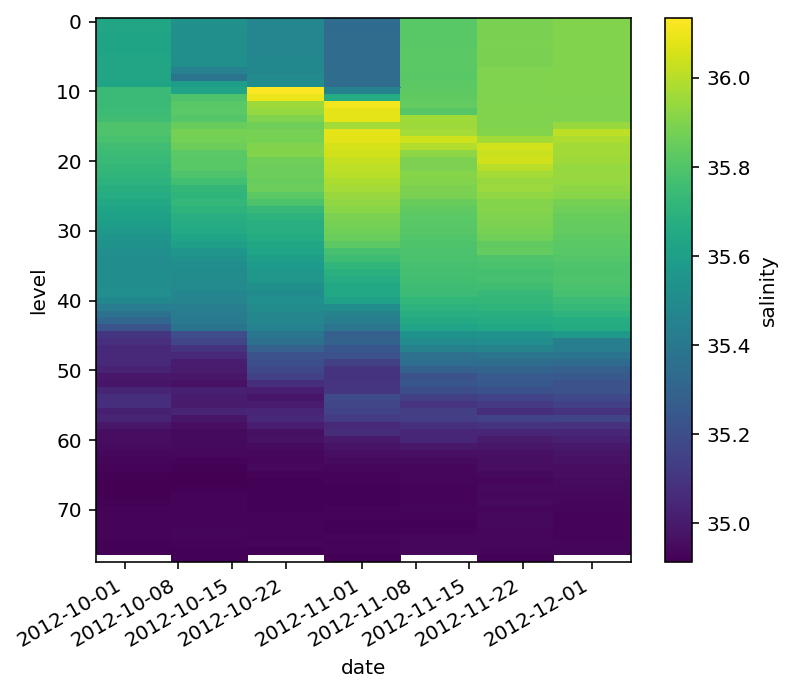

In [127]:
argo.salinity.sel(date=slice('2012-10-01', '2012-12-01')).plot(yincrease=False)

`.sel()` also works on the whole Dataset

In [128]:
argo.sel(date='2012-10-22')

<xarray.Dataset>
Dimensions:      (date: 1, level: 78)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-10-22T02:50:32.006400
    lon          (date) float64 -32.97
    lat          (date) float64 44.13
Data variables:
    salinity     (level, date) float64 35.47 35.47 35.47 ... 34.93 34.92 nan
    temperature  (level, date) float64 17.13 17.13 17.13 ... 3.736 3.639 nan
    pressure     (level, date) float64 6.4 10.3 15.4 ... 1.9e+03 1.951e+03 nan

### Computation

Xarray `DataArrays` and `Datasets` work seamlessly with arithmetic operators and numpy array functions.

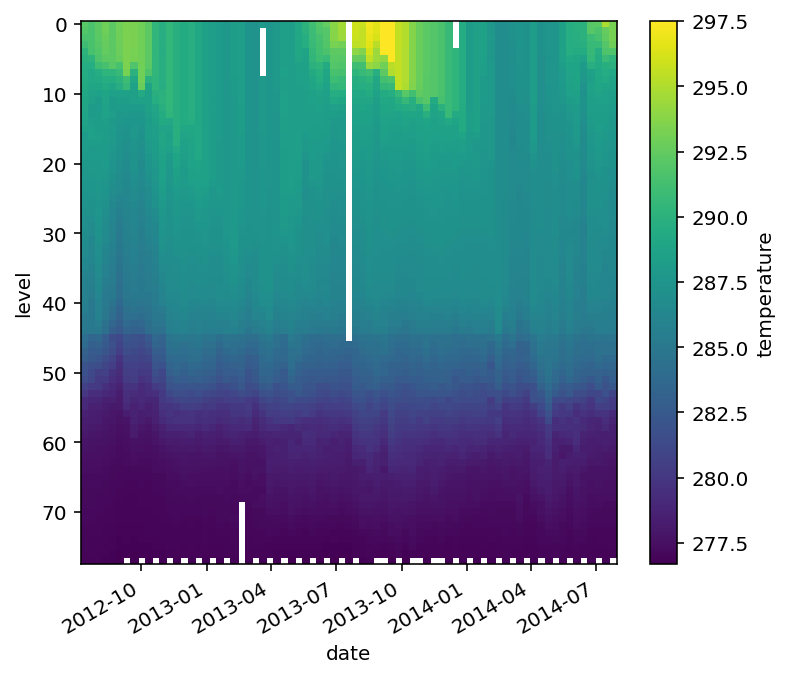

In [129]:
temp_kelvin = argo.temperature + 273.15
temp_kelvin.plot(yincrease=False)

We can also combine multiple xarray datasets in arithemtic operations

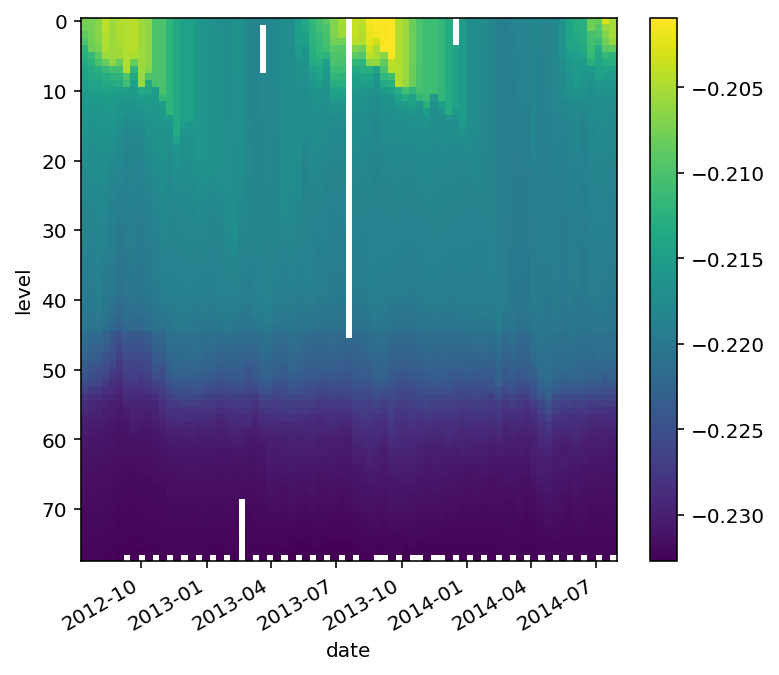

In [130]:
g = 9.8
buoyancy = g * (2e-4 * argo.temperature - 7e-4 * argo.salinity)
buoyancy.plot(yincrease=False)

### Broadcasting

Broadcasting arrays in numpy is a nightmare. It is much easier when the data axes are labeled!

This is a useless calculation, but it illustrates how perfoming an operation on arrays with differenty coordinates will result in automatic broadcasting

In [131]:
level_times_lat = argo.level * argo.lat
level_times_lat

<xarray.DataArray (level: 78, date: 75)>
array([[   0.   ,    0.   ,    0.   , ...,    0.   ,    0.   ,    0.   ],
       [  47.187,   46.716,   46.45 , ...,   42.601,   42.457,   42.379],
       [  94.374,   93.432,   92.9  , ...,   85.202,   84.914,   84.758],
       ...,
       [3539.025, 3503.7  , 3483.75 , ..., 3195.075, 3184.275, 3178.425],
       [3586.212, 3550.416, 3530.2  , ..., 3237.676, 3226.732, 3220.804],
       [3633.399, 3597.132, 3576.65 , ..., 3280.277, 3269.189, 3263.183]])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75 76 77
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...
    lon      (date) float64 -39.13 -37.28 -36.9 -36.89 ... -33.83 -34.11 -34.38
    lat      (date) float64 47.19 46.72 46.45 46.23 ... 42.72 42.6 42.46 42.38

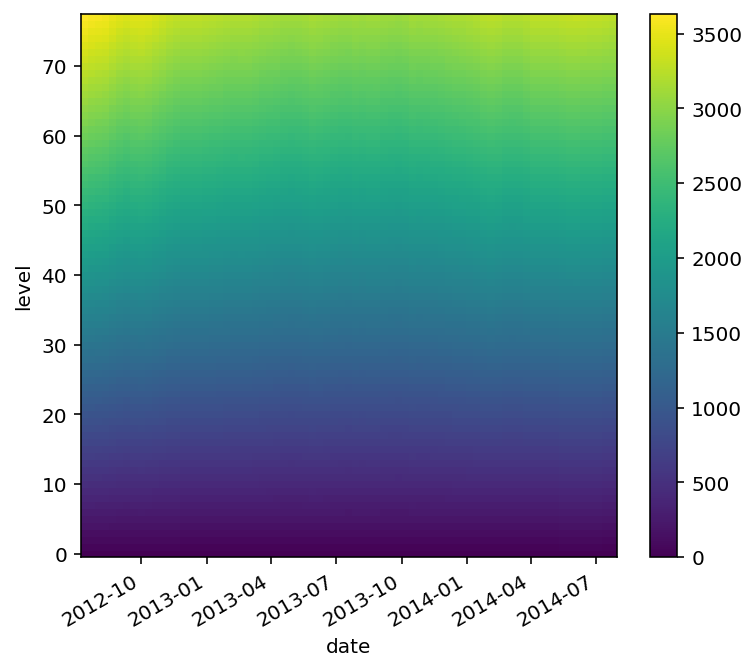

In [132]:
level_times_lat.plot()

### Reductions

Just like in numpy, we can reduce xarray DataArrays along any number of axes:

In [133]:
argo.temperature.mean(axis=0).dims

('date',)

In [134]:
argo.temperature.mean(axis=1).dims

('level',)

However, rather than performing reductions on axes (as in numpy), we can perform them on dimensions. This turns out to be a huge convenience

In [135]:
argo_mean = argo.mean(dim='date')
argo_mean

<xarray.Dataset>
Dimensions:      (level: 78)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
Data variables:
    salinity     (level) float64 35.91 35.9 35.9 35.9 ... 34.94 34.94 34.93
    temperature  (level) float64 17.6 17.57 17.51 17.42 ... 3.789 3.73 3.662
    pressure     (level) float64 6.435 10.57 15.54 ... 1.95e+03 1.999e+03

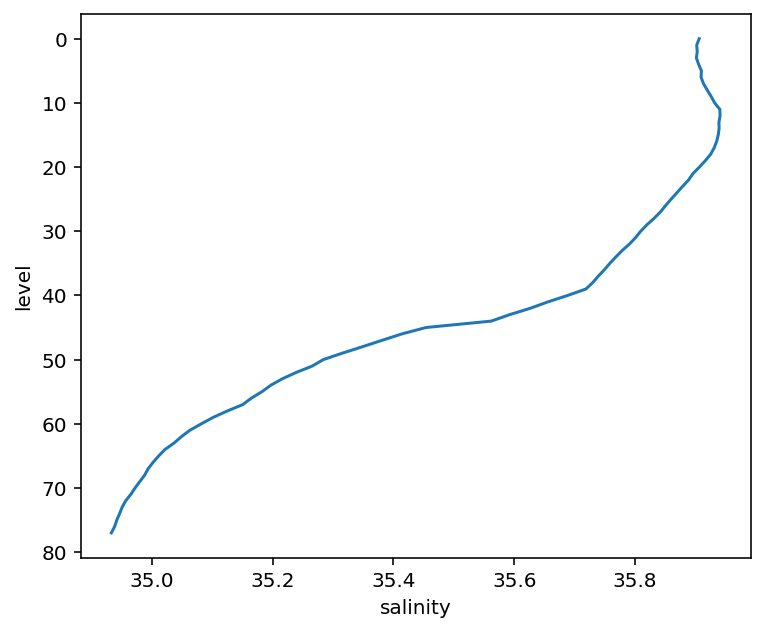

In [136]:
argo_mean.salinity.plot(y='level', yincrease=False)

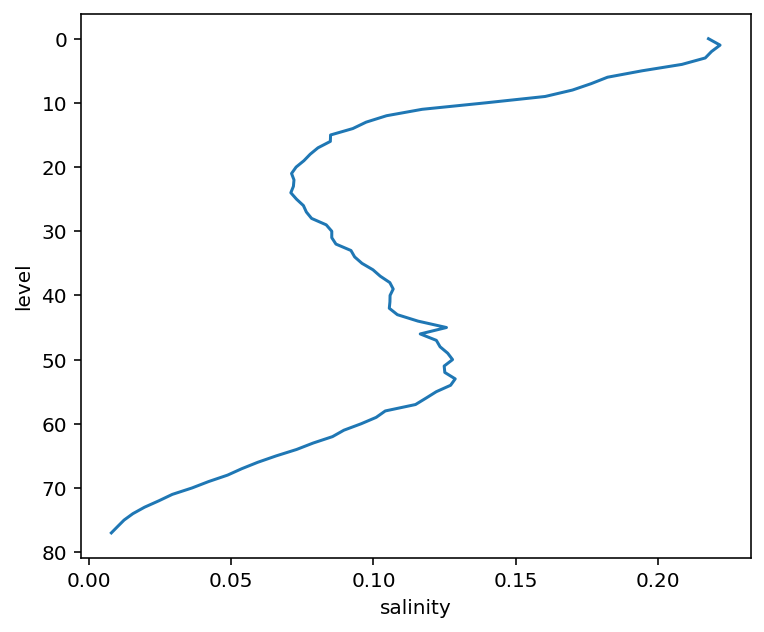

In [137]:
argo_std = argo.std(dim='date')
argo_std.salinity.plot(y='level', yincrease=False)

## Loading Data from netCDF Files

As we already saw, NetCDF (Network Common Data Format) is the most widely used format for distributing geoscience data. NetCDF is maintained by the [Unidata](https://www.unidata.ucar.edu/) organization.

Below we quote from the [NetCDF website](https://www.unidata.ucar.edu/software/netcdf/docs/faq.html#whatisit):

>NetCDF (network Common Data Form) is a set of interfaces for array-oriented data access and a freely distributed collection of data access libraries for C, Fortran, C++, Java, and other languages. The netCDF libraries support a machine-independent format for representing scientific data. Together, the interfaces, libraries, and format support the creation, access, and sharing of scientific data.
>
>NetCDF data is:
>
> - Self-Describing. A netCDF file includes information about the data it contains.
> - Portable. A netCDF file can be accessed by computers with different ways of storing integers, characters, and floating-point numbers.
> - Scalable. A small subset of a large dataset may be accessed efficiently.
> - Appendable. Data may be appended to a properly structured netCDF file without copying the dataset or redefining its structure.
> - Sharable. One writer and multiple readers may simultaneously access the same netCDF file.
> - Archivable. Access to all earlier forms of netCDF data will be supported by current and future versions of the software.


:::{seealso}
Xarray was designed to make reading netCDF files in python as easy, powerful, and flexible as possible. (See [xarray netCDF docs](http://xarray.pydata.org/en/latest/io.html#netcdf) for more details.)
:::

Below we load one the previous eReefs data from the [AIMS server](http://thredds.ereefs.aims.gov.au/thredds/catalog.html). 

In [138]:
month = 3
year = 2020
netCDF_datestr = str(year)+'-'+format(month, '02')

# GBR4 HYDRO
inputFile = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-"+netCDF_datestr+".nc"

ds = xr.open_dataset(inputFile)
ds

<xarray.Dataset>
Dimensions:      (k: 17, latitude: 723, longitude: 491, time: 31)
Coordinates:
    zc           (k) float64 ...
  * time         (time) datetime64[ns] 2020-02-29T14:00:00 ... 2020-03-30T14:...
  * latitude     (latitude) float64 -28.7 -28.67 -28.64 ... -7.096 -7.066 -7.036
  * longitude    (longitude) float64 142.2 142.2 142.2 ... 156.8 156.8 156.9
Dimensions without coordinates: k
Data variables:
    mean_cur     (time, k, latitude, longitude) float32 ...
    salt         (time, k, latitude, longitude) float32 ...
    temp         (time, k, latitude, longitude) float32 ...
    u            (time, k, latitude, longitude) float32 ...
    v            (time, k, latitude, longitude) float32 ...
    mean_wspeed  (time, latitude, longitude) float32 ...
    eta          (time, latitude, longitude) float32 ...
    wspeed_u     (time, latitude, longitude) float32 ...
    wspeed_v     (time, latitude, longitude) float32 ...
Attributes: (12/19)
    Conventions:                     CF-1.0
    Run_ID:                          2.1
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    aims_ncaggregate_buildDate:      2020-08-21T15:38:56+10:00
    aims_ncaggregate_datasetId:      products__ncaggregate__ereefs__gbr4_v2__...
    aims_ncaggregate_firstDate:      2020-03-01T00:00:00+10:00
    ...                              ...
    paramfile:                       in.prm
    paramhead:                       GBR 4km resolution grid
    technical_guide_link:            https://eatlas.org.au/pydio/public/aims-...
    technical_guide_publish_date:    2020-08-18
    title:                           eReefs AIMS-CSIRO GBR4 Hydrodynamic v2 d...
    DODS_EXTRA.Unlimited_Dimension:  time

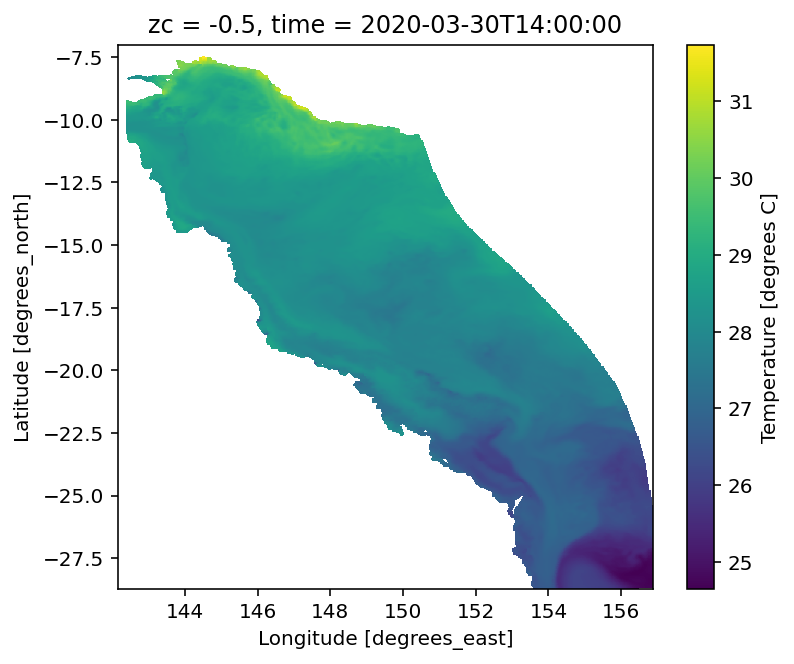

In [139]:
ds.temp.isel(time=-1,k=-1).plot()

Let's use `Cartopy`...

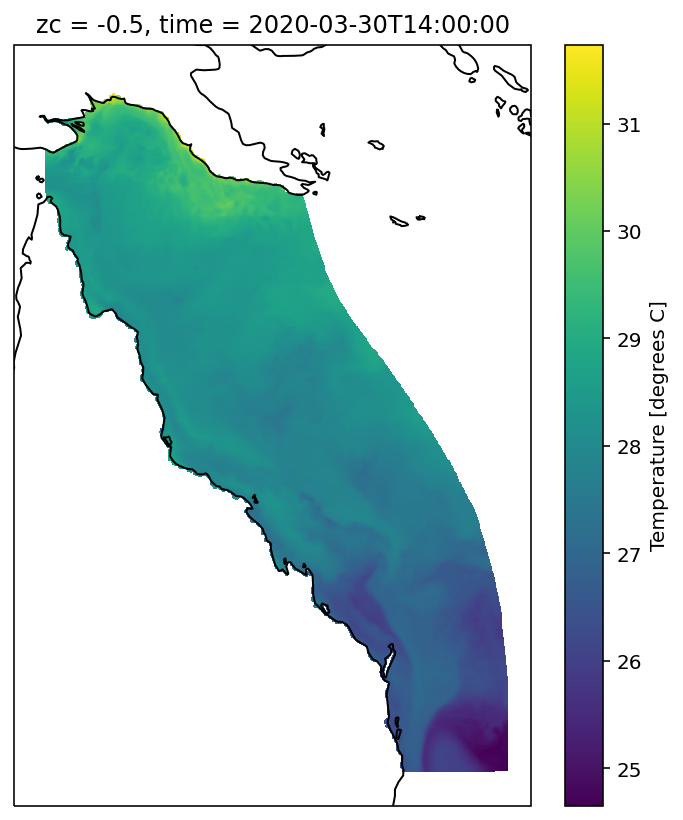

In [142]:
import cartopy.crs as ccrs

fig = plt.figure(figsize=[6, 7])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) 

ds.temp.isel(time=-1,k=-1).plot( 
    transform=ccrs.PlateCarree()
)

ax.coastlines()

In [143]:
ds_slice = ds.sel(time=slice('2020-03-01', '2020-03-14'),k=-1)

In [144]:
ds_slice

<xarray.Dataset>
Dimensions:      (latitude: 723, longitude: 491, time: 14)
Coordinates:
    zc           float64 -0.5
  * time         (time) datetime64[ns] 2020-03-01T14:00:00 ... 2020-03-14T14:...
  * latitude     (latitude) float64 -28.7 -28.67 -28.64 ... -7.096 -7.066 -7.036
  * longitude    (longitude) float64 142.2 142.2 142.2 ... 156.8 156.8 156.9
Data variables:
    mean_cur     (time, latitude, longitude) float32 ...
    salt         (time, latitude, longitude) float32 ...
    temp         (time, latitude, longitude) float32 ...
    u            (time, latitude, longitude) float32 ...
    v            (time, latitude, longitude) float32 ...
    mean_wspeed  (time, latitude, longitude) float32 ...
    eta          (time, latitude, longitude) float32 ...
    wspeed_u     (time, latitude, longitude) float32 ...
    wspeed_v     (time, latitude, longitude) float32 ...
Attributes: (12/19)
    Conventions:                     CF-1.0
    Run_ID:                          2.1
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    aims_ncaggregate_buildDate:      2020-08-21T15:38:56+10:00
    aims_ncaggregate_datasetId:      products__ncaggregate__ereefs__gbr4_v2__...
    aims_ncaggregate_firstDate:      2020-03-01T00:00:00+10:00
    ...                              ...
    paramfile:                       in.prm
    paramhead:                       GBR 4km resolution grid
    technical_guide_link:            https://eatlas.org.au/pydio/public/aims-...
    technical_guide_publish_date:    2020-08-18
    title:                           eReefs AIMS-CSIRO GBR4 Hydrodynamic v2 d...
    DODS_EXTRA.Unlimited_Dimension:  time

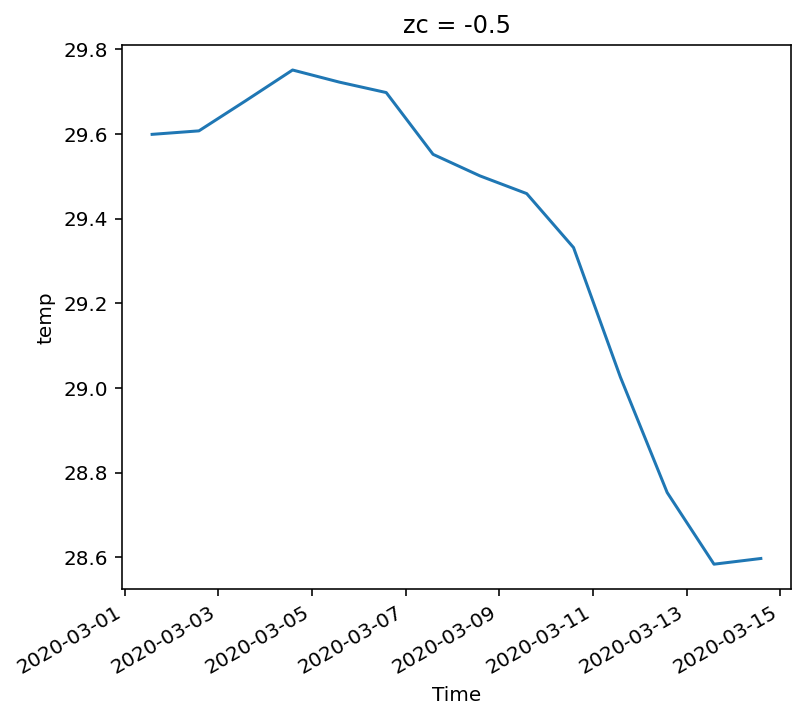

In [145]:
ds_slice.temp.mean(dim=('longitude', 'latitude')).plot()